(1) Jumlah pola makan dengan skor sehat positif: 407
(2) Jumlah pola dengan skor sehat positif & sisa uang positif: 407
(3) Simulasi terbaik ada di index 361
    Skor total   = 54.93
    Skor sehat   = 3.40
    Sisa uang    = 579,000

(4) Jadwal makan simulasi terbaik:
Hari 1: Pagi = warteg, Malam = ayamgeprek
Hari 2: Pagi = capcay, Malam = seblak
Hari 3: Pagi = warteg, Malam = nasipadang
Hari 4: Pagi = gorengan, Malam = nasipadang
Hari 5: Pagi = seblak, Malam = mieayam
Hari 6: Pagi = nasigoreng, Malam = capcay
Hari 7: Pagi = gorengan, Malam = nasigoreng
Hari 8: Pagi = ayamgeprek, Malam = mieayam
Hari 9: Pagi = gorengan, Malam = ayamgeprek
Hari 10: Pagi = capcay, Malam = nasipadang
Hari 11: Pagi = nasipadang, Malam = ayamgeprek
Hari 12: Pagi = nasipadang, Malam = warteg
Hari 13: Pagi = nasigoreng, Malam = mieayam
Hari 14: Pagi = mieayam, Malam = bakso
Hari 15: Pagi = mieayam, Malam = capcay


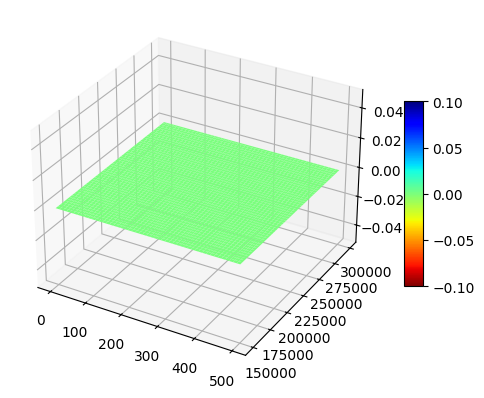

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load data makanan ---
makan = pd.read_csv("makanan.csv")
makan = makan.dropna(subset=['harga'])  # buang data kosong

# --- Parameter simulasi ---
SAMPLE_NUM = 500   # jumlah simulasi
HARI = 15          # jumlah hari simulasi
budget_awal = 1e6  # 1 juta rupiah

# --- Bobot dasar ---
wkenyang_base = 0.8
wrasa_base   = 0.7
wsehat_base  = 0.9
wbosan_base  = 0.2

# --- Array hasil ---
sampleid = np.arange(SAMPLE_NUM)
skor = np.zeros(SAMPLE_NUM)
sisa = np.zeros(SAMPLE_NUM)
sehat = np.zeros(SAMPLE_NUM)
resp_pilih = np.zeros((SAMPLE_NUM, HARI*2), dtype=np.int32)

# --- Simulasi ---
for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(HARI):
        # makan pagi
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base, scale=0.2)
        skor_kumulatif += (
            w_kenyang*makan['kenyang'].iloc[pilihan]
            + w_rasa*makan['rasa'].iloc[pilihan]
            + w_sehat*makan['sehat'].iloc[pilihan]
            - w_bosan*makan['bosan'].iloc[pilihan]
        )
        skor_sehat += makan['sehat'].iloc[pilihan] - 0.5
        budget -= makan['harga'].iloc[pilihan]
        resp_pilih[n][2*i] = pilihan

        # makan malam
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base*2, scale=0.2)
        skor_kumulatif += (
            w_kenyang*makan['kenyang'].iloc[pilihan]
            + w_rasa*makan['rasa'].iloc[pilihan]
            + w_sehat*makan['sehat'].iloc[pilihan]
            - w_bosan*makan['bosan'].iloc[pilihan]
        )
        skor_sehat += makan['sehat'].iloc[pilihan] - 0.5
        budget -= makan['harga'].iloc[pilihan]
        resp_pilih[n][2*i+1] = pilihan

    # simpan hasil simulasi
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat
    sisa[n] = budget


# ANALISIS TUGAS


# (1) Pola makan dengan skor sehat positif
idx_sehat_pos = np.where(sehat > 0)[0]
print(f"(1) Jumlah pola makan dengan skor sehat positif: {len(idx_sehat_pos)}")

# (2) Titik dengan sisa uang bulanan positif dari (1)
idx_valid = idx_sehat_pos[sisa[idx_sehat_pos] > 0]
print(f"(2) Jumlah pola dengan skor sehat positif & sisa uang positif: {len(idx_valid)}")

# (3) Titik dengan skor kumulatif terbesar dari (2)
if len(idx_valid) > 0:
    idx_best = idx_valid[np.argmax(skor[idx_valid])]
    print(f"(3) Simulasi terbaik ada di index {idx_best}")
    print(f"    Skor total   = {skor[idx_best]:.2f}")
    print(f"    Skor sehat   = {sehat[idx_best]:.2f}")
    print(f"    Sisa uang    = {sisa[idx_best]:,.0f}")
else:
    print("(3) Tidak ada pola yang memenuhi kondisi sehat>0 dan sisa uang>0")

# (4) Tampilkan jadwal makanan sesuai pilihan (resp_pilih)
if len(idx_valid) > 0:
    print("\n(4) Jadwal makan simulasi terbaik:")
    for hari in range(HARI):
        pagi = makan['makanan'].iloc[int(resp_pilih[idx_best, 2*hari])]
        malam = makan['makanan'].iloc[int(resp_pilih[idx_best, 2*hari+1])]
        print(f"Hari {hari+1}: Pagi = {pagi}, Malam = {malam}")


# VISUALISASI
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
# Colorize the surface using a colormap
surf = ax.plot_surface(X, Y, resp_sehat,
                       cmap='jet_r',   # try 'plasma', 'coolwarm', etc.
                       edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

Berdasarkan hasil simulasi selama 15 hari, terdapat **407 pola makan** yang mampu menghasilkan skor kesehatan positif. Dari jumlah tersebut, semuanya juga memiliki **sisa uang bulanan yang positif**, sehingga dapat dikatakan tidak hanya sehat tetapi juga terjangkau secara finansial.

Dari seluruh pola makan tersebut, sistem memilih simulasi terbaik yang berada pada **indeks ke-361**. Pada skenario ini, skor total yang diperoleh adalah **54.93**, dengan skor kesehatan sebesar **3.40** dan sisa uang sebesar **Rp579.000**. Nilai ini menunjukkan bahwa pola makan yang dipilih tidak hanya mampu menjaga keseimbangan kesehatan tetapi juga cukup hemat.

Jika diperhatikan dari jadwal yang terbentuk, pola makan harian cenderung bervariasi. Menu yang dipilih bergantian antara **warteg, ayamgeprek, nasi padang, mie ayam, capcay, bakso**, dan lainnya. Pola ini menunjukkan bahwa keberagaman menu ternyata membantu menjaga skor kesehatan tetap positif tanpa membuat pengeluaran membengkak.

Sementara itu, hasil visualisasi 3D menunjukkan distribusi hubungan antara **Sample ID (pola makan), sisa uang, dan skor kesehatan**. Warna yang seragam dan datar pada grafik mengindikasikan bahwa mayoritas titik data berada dalam kisaran nilai skor kesehatan yang rendah, cenderung mendekati nol. Hal ini dapat diartikan bahwa meskipun banyak pola makan yang layak, perbedaan skor kesehatan antar-pola relatif kecil.

Secara keseluruhan, hasil simulasi ini menegaskan bahwa dengan pemilihan pola makan yang tepat, seseorang dapat menjaga kesehatan sekaligus mengelola keuangan secara bijak.